In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import pandas as pd
import numpy as np
import os
import string
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import torch
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset

## Let deep into data

In [10]:
Train_promts = pd.read_csv("/content/drive/MyDrive/DAIGT_dataset/train_v4_drcat_01.csv")
Train_promts.head(10)

,text,label,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human
5,Cell phone use should not be legal while drivi...,0,Phones and driving,persuade_corpus,False,human
6,Phones and Driving\n\nDriving is a good way to...,0,Phones and driving,persuade_corpus,False,human
7,PHONES AND DRIVING\n\nIn this world in which w...,0,Phones and driving,persuade_corpus,False,human
8,People are debating whether if drivers should ...,0,Phones and driving,persuade_corpus,False,human
9,Texting and driving\n\nOver half of drivers in...,0,Phones and driving,persuade_corpus,False,human


In [11]:
Train_essays = pd.read_csv("/content/drive/MyDrive/DAIGT_dataset/train_essays.csv")
Train_essays.head(10)

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
5,00da8c32,1,The electrol college system is an unfair syste...,0
6,011dc2bc,1,"Dear state senator, It is the utmost respect t...",0
7,01448434,0,"Fellow citizens, cars have become a major role...",0
8,01c6e176,1,"""It's official: The electoral college is unfai...",0
9,0202ddf9,1,The Electoral College has been kept for centur...,0


In [12]:
Train_essays.shape

(1378, 4)

### Check our data

model
human      27373
llama      15796
mistral    13439
falcon      4536
gpt         4161
davinci     2099
claude      2000
palm        1733
babbage      698
curie        696
ada          692
cohere       350
Name: count, dtype: int64


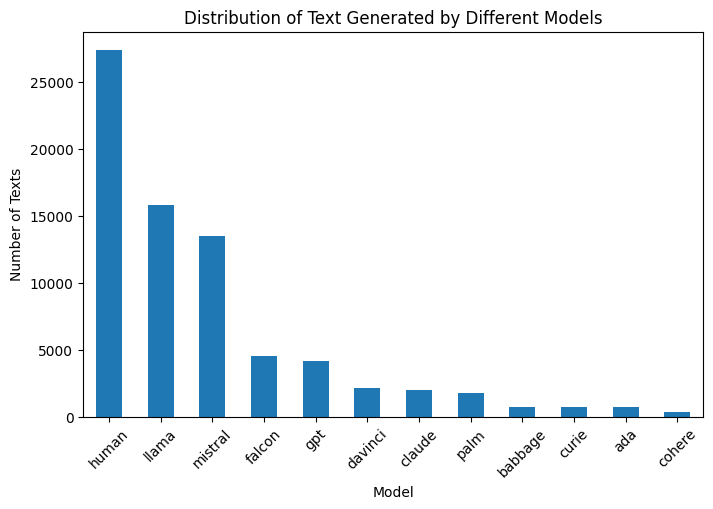

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# load your dataset
df = pd.read_csv("/content/drive/MyDrive/DAIGT_dataset/train_v4_drcat_01.csv")   # change filename if needed

# check distribution counts
model_counts = df["model"].value_counts()

print(model_counts)

# plot histogram / bar chart
plt.figure(figsize=(8,5))
model_counts.plot(kind="bar")

plt.title("Distribution of Text Generated by Different Models")
plt.xlabel("Model")
plt.ylabel("Number of Texts")
plt.xticks(rotation=45)
plt.show()


## Load new dataset
The most relevant datasets are [DAIGT-V4-TRAIN-DATASET](https://www.kaggle.com/datasets/thedrcat/daigt-v4-train-dataset) and [Augmented data for LLM](https://www.kaggle.com/datasets/jdragonxherrera/augmented-data-for-llm-detect-ai-generated-text/data). DAIGIT are newly so i will use it.

In [14]:
Daigit_train = pd.read_csv("/content/drive/MyDrive/DAIGT_dataset/train_v4_drcat_01.csv")
Daigit_train.rename(columns = {"label":"generated"}, inplace=True)
Daigit_train.head()

,text,generated,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human


### Dataset is nice, however contains non-printable characters like \n.
It can reduce our accuracy, so I'll clean it

In [55]:
Train_essays_final = pd.concat([Train_essays[["text", "generated"]], Daigit_train[["text", "generated"]]])

def clean_text(text):
    text = text.replace('\n', ' ')
    text = ''.join(char for char in text if char in string.printable or char.isspace())
    text = ' '.join(text.split())
    return text

Train_essays_final['text'].apply(clean_text)

Train_essays_final.head(10)

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
5,The electrol college system is an unfair syste...,0
6,"Dear state senator, It is the utmost respect t...",0
7,"Fellow citizens, cars have become a major role...",0
8,"""It's official: The electoral college is unfai...",0
9,The Electoral College has been kept for centur...,0


In [45]:
Train_essays_final.shape

(74951, 2)

## Let analyze text length
### It'll help us to choose best model and problematic

In [17]:
Train_essays_final["text_length"] = Train_essays_final["text"].apply(lambda x : len(x.split()))
Train_essays_final.tail()

,text,generated,text_length
73568,I am writing you today to disagree with your t...,1,219
73569,"Dear Principal,\n\nIn conclusion, I would obse...",1,403
73570,"Dear Mrs. Principal,\n\nin these kinds of cons...",1,357
73571,I enjoyed Form five and excitedly ex claims ed...,1,135
73572,"Dear TEACHER_NAME,\n\nWell Ms/Mr TEACHER_NAME ...",1,249


In [18]:
Train_essays_final.describe()

,generated,text_length
count,74951.000000,74951.000000
mean,0.616483,388.622020
std,0.486246,164.854736
min,0.000000,2.000000
25%,0.000000,278.000000
50%,1.000000,363.000000
75%,1.000000,464.000000
max,1.000000,1656.000000


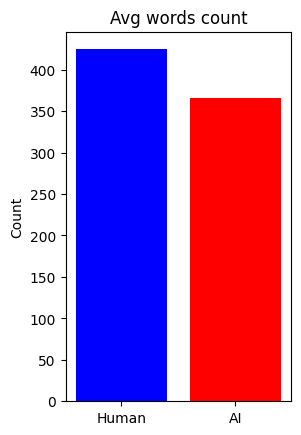

In [19]:
grouped = Train_essays_final.groupby('generated')['text_length'].mean().reset_index()

plt.subplot(1, 2, 2)
plt.bar(grouped['generated'], grouped['text_length'], color=['blue', 'red'])
plt.title('Avg words count')
plt.ylabel('Count')

plt.xticks([0, 1], ['Human', 'AI'])

plt.show()

Nice! Our avg words count is less than 750 words, so we can use TinyBERT or Distill BERT, to improve inference and learning speed, alternative we can use RoBERTa to use all words from text, to improve AUC-ROG.

In [20]:
Train_essays_final = Train_essays_final.drop("text_length", axis=1)
Train_essays_final.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [56]:
import pandas as pd

# Assuming your dataframe is called Train_essays_final
# and the column for labels is 'label'

# Count each class
counts = Train_essays_final['generated'].value_counts()
print(counts)


generated
1    46206
0    28745
Name: count, dtype: int64


In [57]:
import pandas as pd

# Load your Wikipedia dataset
wiki_df = pd.read_csv("/content/drive/MyDrive/DAIGT_dataset/Wikipedia.csv")

# Keep only the text column and add a label column
wiki_df = wiki_df[['Text']].copy()
#rename column Text to text
wiki_df.rename(columns = {'Text':'text'}, inplace=True)


wiki_df['generated'] = 0

In [65]:
# Concatenate the datasets
Train_essays_final = pd.concat([Train_essays_final, wiki_df], ignore_index=True)

# Shuffle the dataset
Train_essays_final = Train_essays_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Optional: check the new label distribution
print(Train_essays_final['generated'].value_counts())

generated
0    48745
1    46206
Name: count, dtype: int64


In [59]:
# Check the data types in the column
print(Train_essays_final['generated'].dtype)

# Count how many values are actually floats
num_float = Train_essays_final['generated'].apply(lambda x: isinstance(x, float)).sum()
print(f"Number of float values in 'generated' column: {num_float}")

# Optionally, see which rows are float
float_rows = Train_essays_final[Train_essays_final['generated'].apply(lambda x: isinstance(x, float))]
print(float_rows)


int64
Number of float values in 'generated' column: 0
Empty DataFrame
Columns: [text, generated]
Index: []


## Model

### Create dataset

In [60]:
labels = Train_essays_final['generated'].tolist()
texts = Train_essays_final['text'].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)



train_dict = {'text': train_texts, 'label': train_labels}
val_dict = {'text': val_texts, 'label': val_labels}

train_dataset_hf = Dataset.from_dict(train_dict)
val_dataset_hf = Dataset.from_dict(val_dict)

In [61]:
train_dataset_hf

Dataset({
    features: ['text', 'label'],
    num_rows: 67960
})

### Train model

TinyBERT

In [62]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# TinyBERT model checkpoint
model_name = "huawei-noah/TinyBERT_General_4L_312D"

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenize
Let's tokenize all datasets before train to avoid bottleneck

In [63]:
def tokenize_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=512)

num_processors = os.cpu_count()
tokenized_train_dataset = train_dataset_hf.map(tokenize_batch, batched=True, num_proc=num_processors)

tokenized_val_dataset = val_dataset_hf.map(tokenize_batch, batched=True, num_proc=num_processors)


tokenized_train_dataset = tokenized_train_dataset.remove_columns(['text'])
tokenized_train_dataset = tokenized_train_dataset.rename_column('label', 'labels')
tokenized_train_dataset.set_format('torch')

tokenized_val_dataset = tokenized_val_dataset.remove_columns(['text'])
tokenized_val_dataset = tokenized_val_dataset.rename_column('label', 'labels')
tokenized_val_dataset.set_format('torch')


Map (num_proc=2):   0%|          | 0/67960 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/16991 [00:00<?, ? examples/s]

### Compute metrics

In [64]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = np.nan_to_num(logits, nan=0.0, posinf=1e6, neginf=-1e6)
    probabilities = softmax(logits, axis=-1)[:, 1]
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    try:
        auc = roc_auc_score(labels, probabilities)
    except ValueError:
        auc = float("nan")

    return {"accuracy": accuracy, "auc": auc}

### Train
From earlier several trials I take these parameters, to improve speed.

In [67]:
# model = BertForSequenceClassification.from_pretrained(
#     MODEL_NAME,
#     num_labels=2
# )


training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/DAIGT_dataset',
    eval_strategy="steps",
    eval_steps=250,
    save_strategy="steps",
    save_steps=250,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    num_train_epochs=1,
    warmup_steps=200,
    logging_dir='./logs',
    logging_steps=50,
    fp16=False,
    bf16=True,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    gradient_checkpointing=False,
    report_to="none",
    optim="adamw_torch",
    load_best_model_at_end=True,
    metric_for_best_model="auc",
    torch_compile=True,
    max_grad_norm=1.0
)

early_stopping = EarlyStoppingCallback(
    early_stopping_patience=1,
    early_stopping_threshold=0.005
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping]
)


trainer.train()


The speedups for torchdynamo mostly come with GPU Ampere or higher and which is not detected here.
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,Auc
250,0.289100,0.218962,0.935672,0.975753
500,0.180100,0.150993,0.950856,0.983786
750,0.154600,0.242920,0.909070,0.986656


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TrainOutput(global_step=750, training_loss=0.2777743415832519, metrics={'train_runtime': 864.6587, 'train_samples_per_second': 78.597, 'train_steps_per_second': 1.228, 'total_flos': 688271818752000.0, 'train_loss': 0.2777743415832519, 'epoch': 0.7062146892655368})

In [68]:
path="/content/drive/MyDrive/DAIGT_dataset/ GlobalModel"
model.save_pretrained(path)
tokenizer.save_pretrained(path)


('/content/drive/MyDrive/DAIGT_dataset/ GlobalModel/tokenizer_config.json',
 '/content/drive/MyDrive/DAIGT_dataset/ GlobalModel/special_tokens_map.json',
 '/content/drive/MyDrive/DAIGT_dataset/ GlobalModel/vocab.txt',
 '/content/drive/MyDrive/DAIGT_dataset/ GlobalModel/added_tokens.json')

### Result

In [69]:
test_data = pd.read_csv("/content/drive/MyDrive/DAIGT_dataset/test_essays.csv")
test_texts = test_data["text"].tolist()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_probabilities = []
batch_size = 64

for i in tqdm(range(0, len(test_texts), batch_size)):
    batch = test_texts[i : i + batch_size]

    inputs = tokenizer(
        batch,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    probabilities = torch.softmax(outputs.logits, dim=-1)


    probs_class_1 = probabilities[:, 1].cpu().numpy()

    all_probabilities.extend(probs_class_1)


submission_df = pd.DataFrame({'id': test_data['id'], 'generated': all_probabilities})
submission_df.to_csv('submission.csv', index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

###  Confusion Matrix

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


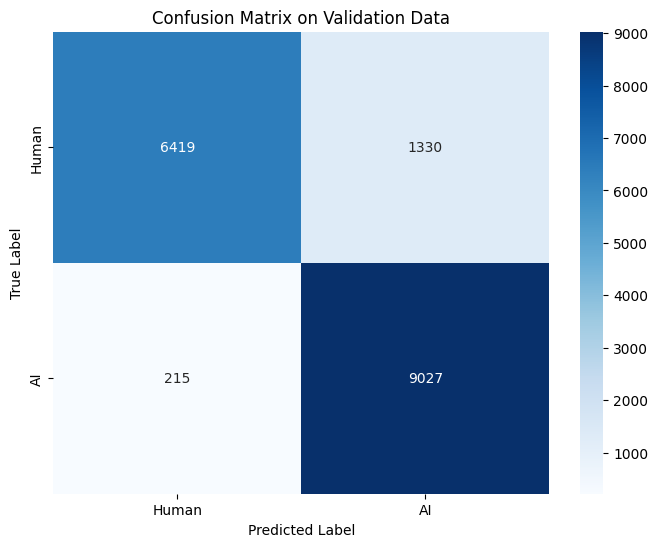

In [70]:

eval_results = trainer.predict(tokenized_val_dataset)

predicted_labels = np.argmax(eval_results.predictions, axis=-1)
true_labels = eval_results.label_ids


cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Human', 'AI'],
            yticklabels=['Human', 'AI'])

plt.title('Confusion Matrix on Validation Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### ROC AUC

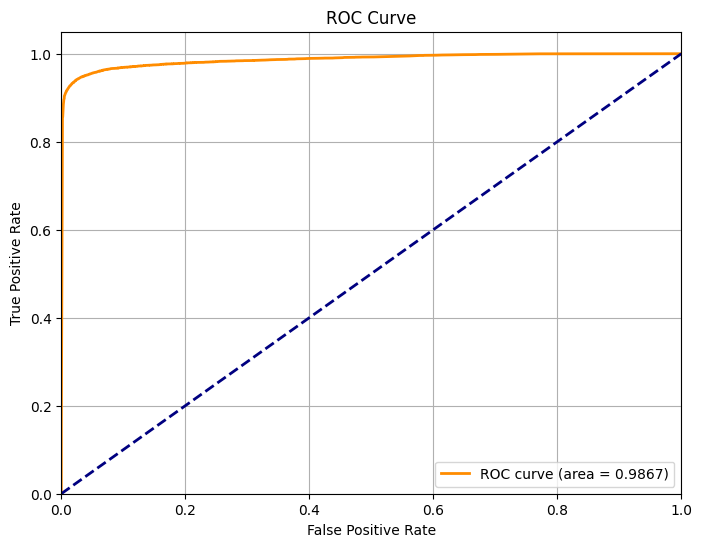

In [71]:
logits = eval_results.predictions

probabilities = softmax(logits, axis=-1)

y_scores = probabilities[:, 1]

y_true = eval_results.label_ids

fpr, tpr, thresholds = roc_curve(y_true, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()